
# Diagnosing Heart Disease of Patient's from Cleveland based on Age, Resting Blood Pressure, Cholesterol, and Max Heart Rate.

## Group 30: Toby Lau, Neil Lin, Tanish Gupta, Kristy Fielding

### Background Information & Introduction

Heart disease is one of the leading causes of death across the United States of America that is caused by a wide variety of factors. Common heart diseases include coronary heart disease, arrhythmias, strokes, etc. Throughout the 21st century, medical professionals have deduced how certain factors may give leeway to one having a certain type of heart disease and the extent of its danger to the human body (Centers for Disease Control and Prevention, 2023). In this project, we will try to determine whether a patient has heart disease given the relevant predictors. The dataset being used is a collection of patients from Cleveland, Ohio, all of whom were suspected to have heart disease. The dataset contains 14 attributes that could contribute to a patient's heart disease. Of the 14, we hope to train a model that is able to classify these stages given some attributes.

**Research Question: How can age, resting blood pressure, cholesterol, and max heart rate determine the stage of heart disease of patients from Cleveland?**

## Methods
To obtain a high quality model trained on the data used, we will have to do some data preprocessing and model tuning.

### Data reading and wrangling
1. Import the required libraries and load the dataset from the web
2. Assign the correct column names and types to the dataset
3. Wrangle the dataset into a tidy format.
4. Split the data into training and testing sets
5. Summarize and visualize data

### Hyperparameter Tuning
1. Set a seed.
2. Create a recipe that defines the "num" column as our response variable and "age", "restbps", "chol", and "thalach" columns as predictors.
3. Scale, center, and upscale the data using the SMOTE algorithm.
4. Create a $k$-nn model  with the neighbors = tune() parameter.
5. Create a tibble with a single neighbors column containing numbers from 1 to 100.
6. Perform Cross-validation on 10 folds.
7. Plot the accuracy of the model against the number of neighbors to determine the $k$ value with the highest accuracy.
8. Using the $k$ value that obtained the highest accuracy, create a new $k$-nn model

### Evaluating
1. Test the model using our testing data set.
2. Check for over/underfitting.
3. Create a confusion matrix
4. Assess the model's performance using tidymodels.


### Data reading and wrangling
First, we import the necessary libraries.

In [8]:
library(tidyverse)
library(ggplot2)
library(GGally)
library(tidymodels)
# install.packages("gridExtra")
# library(gridExtra)
install.packages("themis")
library(themis)

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Then we read in our dataset from the web using read_csv.

In [9]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                          col_names = FALSE)
                          
cleveland_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,3
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2


Table 1

The table above does not contain any column names. Fortunately, the data source contains a variable table that lists the specifications of each column. Using this table we can assign each column of Table 1 its correct name and type. The column names and order were taken from the data source. Using the mutate function, columns that are supposed to be integer are converted to integers with as.integer() and columns that are categorical are converted into factors with as.factor(). The source also mentions only the "ca" and "thal" columns contain missing values but those columns will not be used so they can be removed. Furthermore, only the "age", "chol", "trestbps", and "thalach" columns will be used to create the model so we can select only these columns. Finally, our data is clean.

In [10]:
colnames(cleveland_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
cleveland_data <- cleveland_data |> mutate(age = as.integer(age), sex = as.factor(sex), cp = as.factor(cp), trestbps = as.integer(trestbps), 
                                           chol = as.integer(chol), fbs = as.factor(fbs), restecg = as.factor(restecg),  thalach = as.integer(thalach),
                                           exang = as.factor(exang), oldpeak = as.integer(oldpeak), slope = as.factor(slope), ca = as.integer(ca), 
                                           thal = as.factor(thal), num = as.integer(num)) |> select(age, trestbps, chol, thalach, -ca, -thal, num)
head(cleveland_data)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `ca = as.integer(ca)`.
Caused by warning:
! NAs introduced by coercion”


age,trestbps,chol,thalach,num
<int>,<int>,<int>,<int>,<int>
63,145,233,150,0
67,160,286,108,2
67,120,229,129,1
37,130,250,187,0
41,130,204,172,0
56,120,236,178,0


Table 2

According to the data source, values of 0 in the num column represent patients with <50% vessel diameter narrowing while values > 0 in the num column represent patients with >50% vessel diameter narrowing. Assuming the values 1,2,3,4  distribute the remaining 50% equally, we can separate the "num" column into 3 stages. Mild heart disease is classified as <50% narrowing, moderate heart disease is classified as 50-80% narrowing, and severe heart disease is 80-100% narrowing (Cleveland Clinic). Thus, we assume

| Num value | Percentage blockage | Stage |
| -------- | ------- | ----|
| 0 | < 50% | Mild |
| 1-3 | 50 - 87.5% | Moderate |
| 4 | > 87.5% | Severe |

This allows us to bucket the "num" column values into stages, represented by a new "stage" column.

In [22]:
cleveland_data <- cleveland_data |> 
    mutate(stage = cut(num, breaks=c(-Inf,0,4), labels=c("Mild","Moderate/Severe"))) #0 = mild, 1-3 = moderate, 4 = severe
head(cleveland_data)

age,trestbps,chol,thalach,num,stage
<int>,<int>,<int>,<int>,<int>,<fct>
63,145,233,150,0,Mild
67,160,286,108,2,Moderate/Severe
67,120,229,129,1,Moderate/Severe
37,130,250,187,0,Mild
41,130,204,172,0,Mild
56,120,236,178,0,Mild


Table 3 \
Now we can separate the dataset into training and testing splits. We used a seed of 69 for the rest of the report.

In [43]:
set.seed(69)

split <- initial_split(cleveland_data, prop=0.75, strata = stage)
data_training <- training(split)
data_testing <- testing(split)

head(data_training)
training_summary <- data_training |> group_by(stage) |> summarize(count = n())
training_summary

age,trestbps,chol,thalach,num,stage
<int>,<int>,<int>,<int>,<int>,<fct>
63,145,233,150,0,Mild
37,130,250,187,0,Mild
57,120,354,163,0,Mild
57,140,192,148,0,Mild
44,120,263,173,0,Mild
52,172,199,162,0,Mild


stage,count
<fct>,<int>
Mild,123
Moderate/Severe,104


In the code above, we have split our data into both a training and testing set. The purpose of using intital_split is to ensure that bias and order were removed. There are 227 rows (75%) in the training set and 76 rows (25%) in the testing set. With this respective proportion, we will have enough data to sufficiently train our model and then utilize the testing set to evaluate its performance on unseen data. 

### Summarizing and Visualizing the Data
With our training set, we can summarize and visualize our training data to uncover any underlying patterns in relation to our new "stage" column. The following code will present four respective density plots, all of which showcase our four predictors colouring with stage. 

Density plots were used as opposed to histograms or scatter plots to reduce noise and simplify interpretations. 

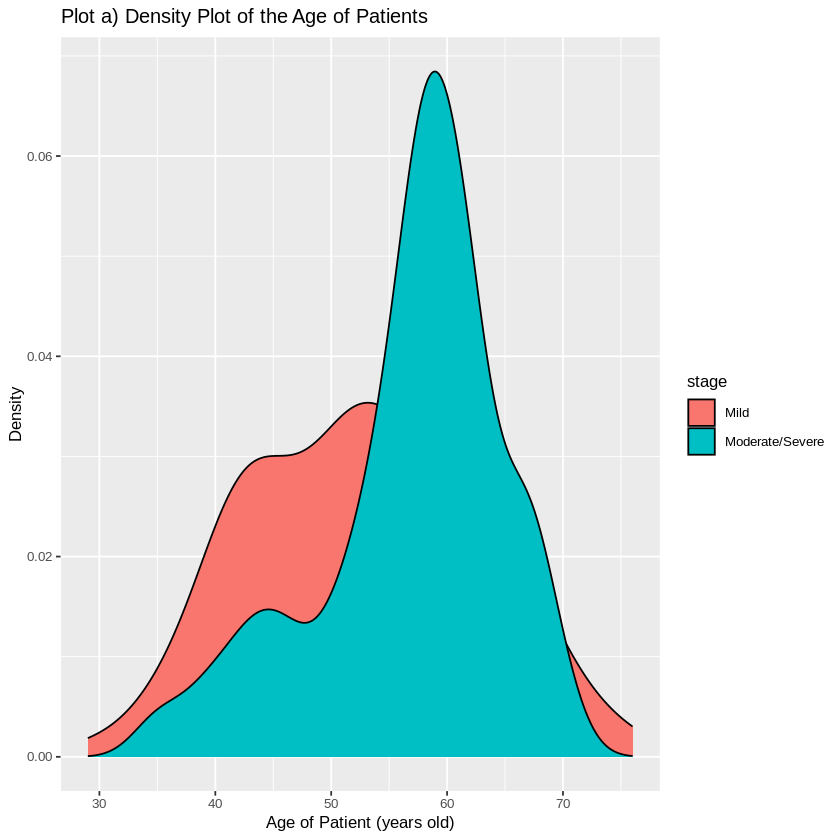

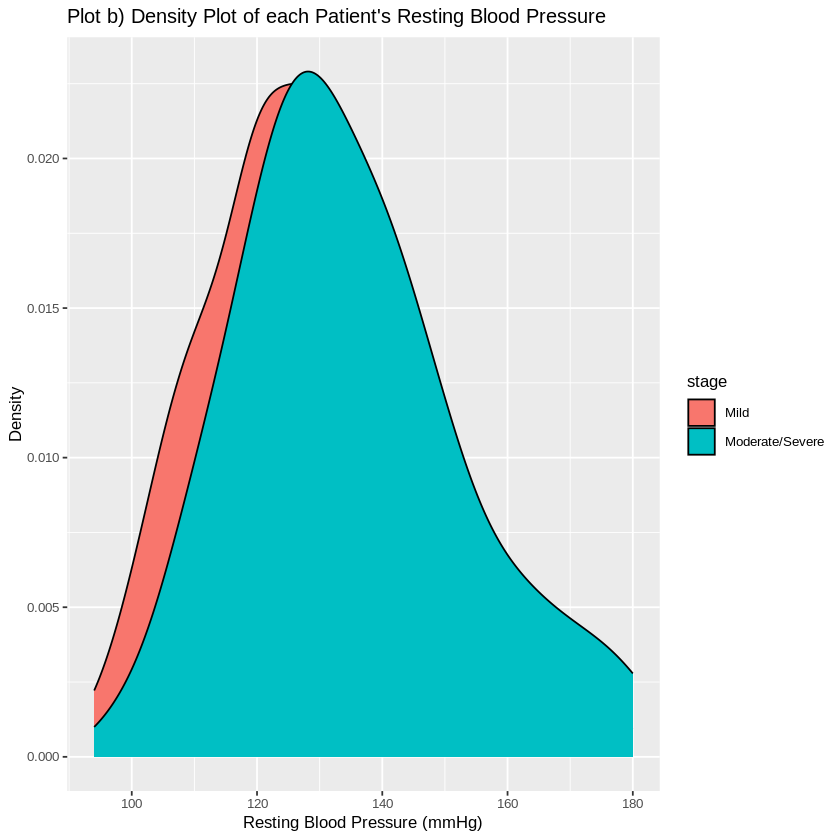

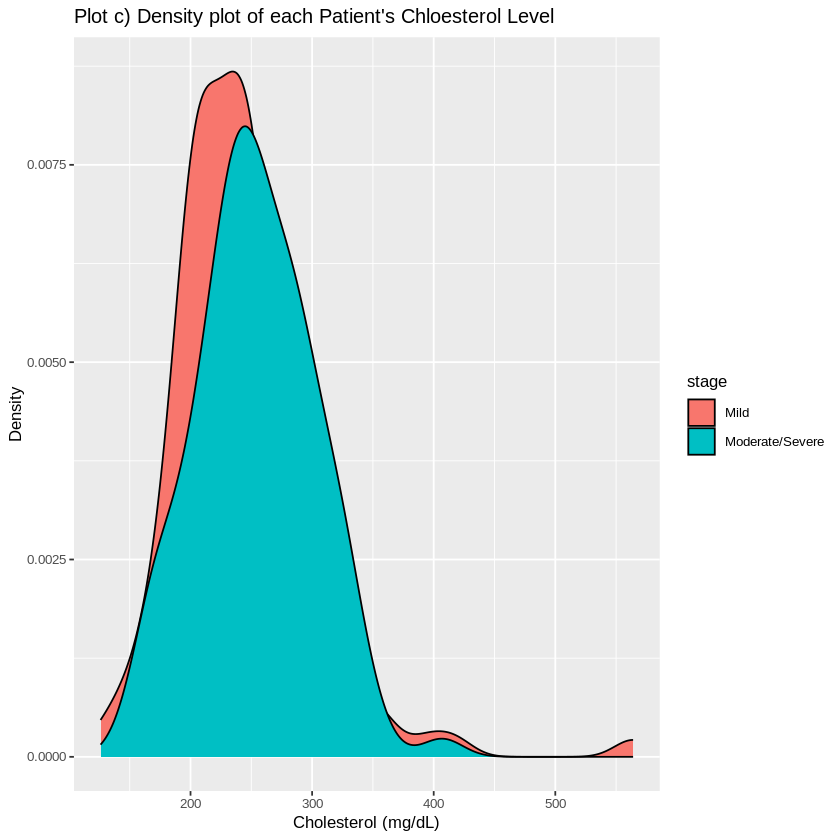

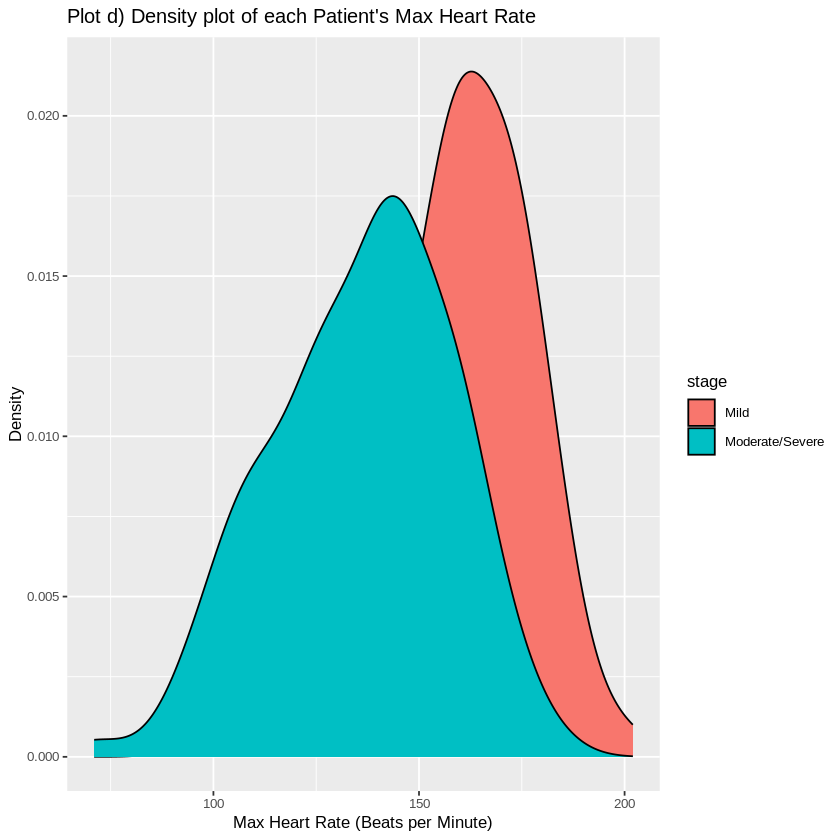

In [44]:
#Predictor 1 = age
#Predictor 2 = Resting Blood Pressure
#Predictor 3 = Cholesterol
#Predictor 4 = Max Heart Rate
options(options.repr.width = 10, options.repr.height = 10)

predictor_1 <- data_training |>
    ggplot(aes(x = age, fill = stage))+
    geom_density()+
    labs(x = "Age of Patient (years old)", y = "Density", title = "Plot a) Density Plot of the Age of Patients")+
    theme(text = element_text(size = 10))

predictor_2 <- data_training |>
    ggplot(aes(x = trestbps, fill = stage))+
    geom_density()+
    labs(x = "Resting Blood Pressure (mmHg)", y = "Density", title = "Plot b) Density Plot of each Patient's Resting Blood Pressure ")+
    theme(text = element_text(size = 10))

predictor_3 <- data_training |>
    ggplot(aes(x = chol, fill = stage))+
    geom_density()+
    labs(x = "Cholesterol (mg/dL)", y = "Density", title = "Plot c) Density plot of each Patient's Chloesterol Level")+
    theme(text = element_text(size = 10))

predictor_4 <- data_training |>
    ggplot(aes(x = thalach, fill = stage))+
    geom_density()+
    labs(x = "Max Heart Rate (Beats per Minute)", y = "Density", title = "Plot d) Density plot of each Patient's Max Heart Rate")+
    theme(text = element_text(size = 10))

predictor_1
predictor_2
predictor_3
predictor_4

# summary <- grid.arrange(predictor_1, predictor_2, predictor_3, predictor_4, nrow = 2)
# summary

**Predictor 1 (Age)**

As per the graph it is evident that with an increase in age, individuals with existing heart disease, face a more severe stage of condition. Therefore, we can infer a proportional relationship between age and severity of heart disease.

**Predictor 2 (Resting Blood Pressure)**

As per the graph it is evident that with an increase in resting blood pressure, individuals with existing heart disease, face a more severe stage of condition. Therefore, we can infer a proportional relationship between resting blood pressure and severity of heart disease.

**Predictor 3 (Cholesterol)**

???

**Predictor 4 (Max Heart Rate)**

As per the graph it is evident that with a decrease in max heart rate, individuals with existing heart disease, face a more severe stage of condition. Therefore, we can infer an inverse relationship between max heart rate and severity of heart disease.

### Identifying the Ideal K Value

To identify the ideal K value, we create a model for each $k$ from 1 to 100 and select the $K$ value that obtained the highest accuracy.

In [51]:
set.seed(69)

k_vals <- tibble(neighbors = seq(1,100,1))

tune_recipe <- recipe(stage ~ age + chol + trestbps + thalach, data = data_training) |>
    # step_upsample(stage) |>
    step_scale(all_predictors()) |> 
    step_center(all_predictors()) 

tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

tune_cv <- vfold_cv(data_training, v = 10, strata = stage)

tune_wf <- workflow() |>
    add_recipe(tune_recipe) |>
    add_model(tune_spec)

tune_results <- tune_wf |>
    tune_grid(resamples = tune_cv, grid = k_vals) |>
    collect_metrics()

tune_results

# # your code here
# knn_recipe <- recipe(y ~ ., data = training_set) 

# knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
#     set_engine("kknn") |>
#     set_mode("classification")

# knn_workflow <- workflow() |>
#     add_model(knn_spec) |>
#     add_recipe(knn_recipe)

# knn_vfold <- vfold_cv(training_set, v = 5, strata = y) 

# gridvals <- tibble(neighbors = seq(2,6,1))

# res <- knn_workflow |>
#     tune_grid(resamples = knn_vfold, grid = gridvals) |>
#     collect_metrics() |>
#     filter(.metric == "accuracy")
# res

# cross_val_plot <- res |>
#     ggplot(aes(x=neighbors, y = mean)) +
#     geom_point() +
#     geom_line() + 
#     ggtitle("K-value vs Mean accuracy") +
#     labs(x = "Neighbors", y = "Mean accuracy")
# cross_val_plot
# # were using accuracy here so we want max(mean)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6123847,10,0.02218276,Preprocessor1_Model001
1,roc_auc,binary,0.6107343,10,0.02145355,Preprocessor1_Model001
2,accuracy,binary,0.6123847,10,0.02218276,Preprocessor1_Model002
2,roc_auc,binary,0.6172057,10,0.03476213,Preprocessor1_Model002
3,accuracy,binary,0.6430665,10,0.03000973,Preprocessor1_Model003
3,roc_auc,binary,0.6594260,10,0.03341496,Preprocessor1_Model003
4,accuracy,binary,0.6430665,10,0.03000973,Preprocessor1_Model004
4,roc_auc,binary,0.6901078,10,0.03295466,Preprocessor1_Model004
5,accuracy,binary,0.6835968,10,0.03017770,Preprocessor1_Model005


In [52]:
a <- tune_results |> filter(.metric == "accuracy") |> arrange(desc(mean))
a

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
73,accuracy,binary,0.7269269,10,0.03460943,Preprocessor1_Model073
74,accuracy,binary,0.7269269,10,0.03460943,Preprocessor1_Model074
77,accuracy,binary,0.7269269,10,0.03325635,Preprocessor1_Model077
78,accuracy,binary,0.7269269,10,0.03325635,Preprocessor1_Model078
55,accuracy,binary,0.7225791,10,0.03278712,Preprocessor1_Model055
56,accuracy,binary,0.7225791,10,0.03278712,Preprocessor1_Model056
99,accuracy,binary,0.7220026,10,0.02888952,Preprocessor1_Model099
100,accuracy,binary,0.7220026,10,0.02888952,Preprocessor1_Model100
65,accuracy,binary,0.7185935,10,0.03875466,Preprocessor1_Model065


## Discussion

## References